In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

locc = "LOCAL"

if locc == "LOCAL":

    #veri setinin indirilip dosya yollarının kaydedilmesi

    movielens_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"

    downloaded_path = tf.keras.utils.get_file(movielens_url.rsplit('/').pop(), movielens_url, extract=True)

    dataset_dir = Path(downloaded_path).parent / Path(downloaded_path).stem
    print(dataset_dir)

    #indirelen veri setinin ilgili csv dosyaları pandas dataframe olarak atandı

elif locc == "COLAB":

    dataset_dir = Path("/content")
    print(dataset_dir)

    ! pip install -q kaggle
    from google.colab import files
    files.upload()

    ! mkdir ~/.kaggle
    ! mv kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json

    ! kaggle datasets download "shubhammehta21/movie-lens-small-latest-dataset"
    ! unzip -j "movie-lens-small-latest-dataset"

else:
    raise RuntimeError

2.12.0


C:\Users\feind\.keras\datasets\ml-latest-small


In [55]:
ratings_file = dataset_dir / "ratings.csv"
ratings = pd.read_csv(
    ratings_file
)

movies_file = dataset_dir / "movies.csv"
movies = pd.read_csv(
    movies_file
)

#TODO doğal dil işleme ile kullanıcıların ilgili filme yaptığı yorumlar çıkarılabilir

# tags_file = dataset_dir / "tags.dat"
# tags = pd.read_csv(tags_file)

In [ ]:
ratings.info()

In [ ]:
ratings.head(10)

In [ ]:
movies.info()

In [ ]:
movies.head(10)

In [56]:
perc = 0.5

In [57]:
def round_of_rating(number):
    return round(number * 2.0) / 2.0

In [58]:
from sklearn.model_selection import train_test_split

ratings_df = ratings.copy()

np.random.seed(1337)

counts = ratings_df["movieId"].value_counts()

non_one_columns = ratings[~ratings["movieId"].isin(counts[counts == 1].index)]
one_columns = ratings[ratings["movieId"].isin(counts[counts == 1].index)]

train_df, test_df = train_test_split(non_one_columns, test_size=0.2, random_state=1337, stratify=non_one_columns["movieId"])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=1337, stratify=train_df["movieId"])

train_df = pd.concat([train_df, one_columns])

train_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')

column_means = np.nanmean(train_matrix, axis=0)
train_missing_indices = np.where(np.isnan(train_matrix))
indices = np.random.choice(train_missing_indices[0].shape[0], int(train_missing_indices[0].shape[0] * perc), replace=False)
user_indices = train_missing_indices[0][indices]
movie_indices = train_missing_indices[1][indices]
train_missing_indices = (user_indices, movie_indices)

for i in range(train_missing_indices[0].shape[0]):
    train_matrix.iloc[train_missing_indices[0][i], train_missing_indices[1][i]] = column_means[train_missing_indices[1][i]]

filled_train_df = pd.DataFrame(
    data=train_matrix,
    index=train_df['userId'].unique(),
    columns=train_df['movieId'].unique()
)

filled_train_df.index.name = 'userId'
filled_train_df.columns.name = 'movieId'

filled_train_df = filled_train_df.stack().reset_index()
filled_train_df.columns = ['userId', 'movieId', 'rating']

filled_train_df["rating"] = filled_train_df["rating"].apply(lambda x: round_of_rating(x))

ratings = filled_train_df
ratings

,userId,movieId,rating
0,139,5459,2.0
1,139,2571,4.0
2,139,71535,3.5
3,139,7153,4.0
4,139,783,3.5
...,...,...,...
2998702,518,146309,4.0
2998703,518,160341,2.5
2998704,518,160527,4.5
2998705,518,160836,3.0


In [60]:
len(ratings["movieId"].unique())

9724

In [61]:
#filmlerin kaç farklı türü olduğu bulundu ve bu bulunan türler "movies" dataframe'ine sütun olarak eklendi
unique_genres = pd.unique(movies["genres"].str.split("|", expand=True).values.ravel())
movies[unique_genres] = 0

#hafızada daha az yer kaplaması açısından bu film türlerini tutan sütunlar 1 byte olarak tutuldu
movies = movies.astype({x: np.int8 for x in unique_genres})

#bir yukarıdaki hücrede de görüleceği üzere indirilen dataframe'de film türleri tek sütünda ve "|" sembolü ile ayrılmış durumda
#üstteki 3 satırlık kodda bu türleri kendi ayrı sütunlarına almıştık
#alttaki for döngüsünde ise ilgili filme denk gelen tür sütunları eğer bu filmin türünü barındırıyor ise 1 yapıldı
#eğer barındırmıyor ise üstteki ilgili koddan dolayı 0 olarak kaldı
#örneğin "3" numaralı filmin türleri "Comedy|Romance" olduğu için
#movies dataframe'inin "Comedy" ve "Romance" sütununun değerleri "3" numaralı film için 1 oldu
for index, row in enumerate(movies["genres"].str.split("|")):
    movies.loc[index, row] = 1

movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieId             9742 non-null   int64 
 1   title               9742 non-null   object
 2   genres              9742 non-null   object
 3   Adventure           9742 non-null   int8  
 4   Animation           9742 non-null   int8  
 5   Children            9742 non-null   int8  
 6   Comedy              9742 non-null   int8  
 7   Fantasy             9742 non-null   int8  
 8   None                9742 non-null   int8  
 9   Romance             9742 non-null   int8  
 10  Drama               9742 non-null   int8  
 11  Action              9742 non-null   int8  
 12  Crime               9742 non-null   int8  
 13  Thriller            9742 non-null   int8  
 14  Horror              9742 non-null   int8  
 15  Mystery             9742 non-null   int8  
 16  Sci-Fi              9742

In [62]:
#bir yukarıdaki hücrede bu türleri filmlere göre haritaladığımız için
#dataframe'de bulunan "genres" ve "title" sütunlarını hafızadan kazanmak için sildik
#böylece elimizde sadece ilgili filmin "id"si ve türleri kaldı
movies = movies.drop(["genres", "title"], axis=1)
movies.head(10)

,movieId,Adventure,Animation,Children,Comedy,Fantasy,None,Romance,Drama,Action,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,10,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [63]:
#rating dataframe'inde ilgili kullanıcının ilgili filme kaç puan verdiği bulunuyor ama bu filmin hangi türlere sahip olduğu bulunmuyor
#bu yüzden yukarıdaki hücrelerde oluşturduğumuz "movies" dataframe'indeki ilgili "id"
#ratings dataframe'indeki "movieId"ler ile haritalandı
ratings = ratings.join(movies.set_index("movieId"), on="movieId", how="inner")

In [64]:
#kullanılmadığı için "timestamp" sütunu dataframe'den silindi ve
#kullanılacak modelin veriyi ezberlemesinden kaçınmak için dataframe'in satırları rastgele olarak karıştırıldı
#ratings = ratings.drop("timestamp", axis=1)
ratings = ratings.sample(frac=1, random_state=1337)
ratings.head(10)

,userId,movieId,rating,Adventure,Animation,Children,Comedy,Fantasy,None,Romance,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
785638,116,193567,3.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2693825,126,99007,3.5,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1056325,149,7208,4.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2559640,154,32442,2.5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2409602,424,89864,3.5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2751569,439,42,3.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1238881,1,155743,2.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1050486,475,1401,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1167479,526,2052,2.5,0,0,1,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
526704,43,4846,3.5,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Optional

In [ ]:
# hyperparameter tuningde train çok üzün sürüyor veriyi bölelim

ratings = ratings[:int(0.1 * len(ratings))]

In [65]:
#daha sonra kullanmak adına tekil kullanıcı sayısı ve film sayısı bulundu
num_unique_users = len(ratings["userId"].unique())
num_unique_movies = len(ratings["movieId"].unique())

#daha sonra kullanmak adına herhangi bir kullanıcı tarafından verilen en düşük ve en yüksek puan bulundu
min_rating = ratings["rating"].min()
max_rating = ratings["rating"].max()

#modele giriş olarak verilecek değerler x_train değişkeninde toplandı
#bunlar kullanıcı, film "id"leri ve ilgili filmin türleri
x_train = ratings.drop("rating", axis=1).values

#filmlere kullanıcılar tarafından verilen puanlar reel sayılar kümesinde tanımlı olmadığı için
#örneğin 3.123 veya 1.567 olmadığı; 0.5, 2.5, 4.0 gibi belirli bir oranda artan sonlu sayılar kümesini oluşturduğu için
#bu değerler kategorisel olarak tutuldu
#örneğin bir kullanıcı bir filme 2.5 verdiyse min_rating değişkeninde başlamak ve max_rating değişkeninde bitmek üzere
#ilgili oranda artan(bu durumda 0.5) bir kategori kümesi oluşturuldu
#bu kategori kümesinde 2.5 puanı hangi kategori indisine denk geliyorsa ise o kategori indisinin değeri 1 yapıldı
y_labels = ratings["rating"]

#ilginç bir hata yüzünden
from sklearn.preprocessing import LabelEncoder
y_train = keras.utils.to_categorical(LabelEncoder().fit_transform(y_labels))

# y_train = keras.utils.to_categorical(sk.preprocessing.LabelEncoder().fit_transform(y_labels))

In [146]:
max_sequence_length = 8

sequences_x = []
sequences_y = []

users = np.unique(x_train[:, 0])

for user in users:

    movie_data = x_train[x_train[:, 0] == user]

    sequence = []
    sequence_y = []

    if len(movie_data) >= max_sequence_length:
        num_sequences = len(movie_data) // max_sequence_length
        for i in range(num_sequences):
            start_index = i * max_sequence_length
            end_index = start_index + max_sequence_length
            sequence = movie_data[start_index:end_index]
            sequences_x.append(sequence)

            for j in sequence[:, 1]:
                y_index = np.where((x_train[:, 0] == user) & (x_train[:, 1] == j))[0][0]
                sequence_y.append(y_train[y_index])

            sequences_y.append(np.array(sequence_y, dtype=np.float32))
            sequence_y = []
    else:
        padding_length = max_sequence_length - len(movie_data)
        sequence = np.pad(movie_data, ((0, padding_length), (0, 0)), 'constant')
        sequences_x.append(sequence)

        for j in range(len(movie_data)):
            y_index = np.where((x_train[:, 0] == user) & (x_train[:, 1] == sequence[j, 1]))[0][0]
            sequence_y.append(y_train[y_index])

        sequence_y = np.pad(sequence_y, ((0, padding_length), (0, 0)), 'constant')
        sequences_y.append(np.array(sequence_y, dtype=np.float32))

    # print("x", sequence.shape)
    # print("len ", len(movie_data), " y ", np.array(sequence_y, dtype=np.float32).shape)



In [66]:
#burada yukarıdaki hücrede x_train değişkeninde tutulan giriş verilerini görsel olarak görebiliyoruz
#ilk iki eleman kullanıcı, film "id"leri olmak üzere geri kalan değerler ise ilgili filmin
#sahip olduğu(bu durumda 1 değerini alan) ve/veya olmadığı(bu durumda 0 değerini alan) değerleri tutan türleri görüyoruz
x_train[:3]

array([[   116, 193567,      0,      1,      0,      0,      0,      0,
             0,      1,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   126,  99007,      0,      0,      0,      1,      0,      0,
             1,      0,      0,      0,      0,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   149,   7208,      0,      0,      0,      0,      0,      0,
             0,      1,      0,      0,      0,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0]],
      dtype=int64)

In [67]:
#bu hücrede yukarıda anlatılmaya çalışılan mantık görsel olarak görülüyor
#bu dizaynın uygulanma nedeni ise oluşturulan modelin ilgili reel sayı aralığında tahmin yapması yerine
#ilgili puan kategorilerinden(0.5, 2.0, 4.5 gibi) hangisi olduğunu tahmin etmesi yeterli hale gelecek ve
#daha doğru bir çıktı elde edilecek olmasıdır
y_train[:3]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

Eğer Veri Seti Validation ve Test olarak bölünmüşse

In [68]:
val_df2 = val_df.join(movies.set_index("movieId"), on="movieId", how="inner")
test_df2 = test_df.join(movies.set_index("movieId"), on="movieId", how="inner")

val_df2 = val_df2.drop("timestamp", axis=1)
val_df2 = val_df2.sample(frac=1, random_state=1337)
test_df2 = test_df2.drop("timestamp", axis=1)
test_df2 = test_df2.sample(frac=1, random_state=1337)

x_val = val_df2.drop("rating", axis=1).values
y_vallabels = val_df2["rating"]
y_val = keras.utils.to_categorical(LabelEncoder().fit_transform(y_vallabels))

x_test = test_df2.drop("rating", axis=1).values
y_testlabels = test_df2["rating"]
y_test = keras.utils.to_categorical(LabelEncoder().fit_transform(y_testlabels))

In [ ]:
del ratings
del movies
# del tags
del y_labels

import gc
gc.collect()

63

In [69]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))
print(len(x_test))
print(len(y_test))

2998707
2998707
15583
15583
19478
19478


In [70]:
x_val

array([[  451,   481,     0, ...,     0,     0,     0],
       [  313,  1059,     0, ...,     0,     0,     0],
       [   68,  1892,     0, ...,     0,     0,     0],
       ...,
       [  380, 56174,     0, ...,     0,     0,     0],
       [  103,  5014,     0, ...,     0,     0,     0],
       [   91,  1373,     0, ...,     0,     0,     0]], dtype=int64)

In [71]:
x_test

array([[  318, 27773,     0, ...,     0,     0,     0],
       [  123,   293,     0, ...,     0,     0,     0],
       [  305,  2664,     0, ...,     0,     0,     0],
       ...,
       [  387,  2245,     0, ...,     0,     0,     0],
       [   68,  4226,     0, ...,     0,     0,     0],
       [  555,   440,     0, ...,     0,     0,     0]], dtype=int64)

(array([  920.,  1879.,  1222.,  4981.,  3675., 13027.,  8697., 17288.,
         5550.,  8536.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

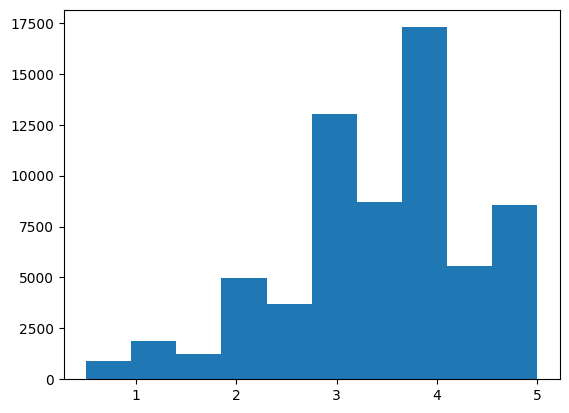

In [14]:
_, indices = np.where(y_train == 1)
ratings_for_hist = np.apply_along_axis(lambda x: x * 0.5 + min_rating, 0, indices)

plt.hist(ratings_for_hist)

In [ ]:
!pip install fitter

Fitting 110 distributions:  86%|████████▋ | 95/110 [11:19<02:02,  8.15s/it]/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distributions:  90%|█████████ | 99/110 [11:37<00:56,  5.13s/it]/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1225: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
Fitting 110 distr

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
rdist,16.451328,inf,-545477.528665,inf,0.807267,0.0
gausshyper,17.766407,481.396624,-540385.936053,inf,0.219173,0.0
arcsine,17.928263,508.308802,-539833.801234,inf,0.373933,0.0
beta,17.993271,535.769768,-539573.542897,inf,0.326065,0.0
dgamma,18.002202,576.739382,-539551.997458,inf,0.187715,0.0


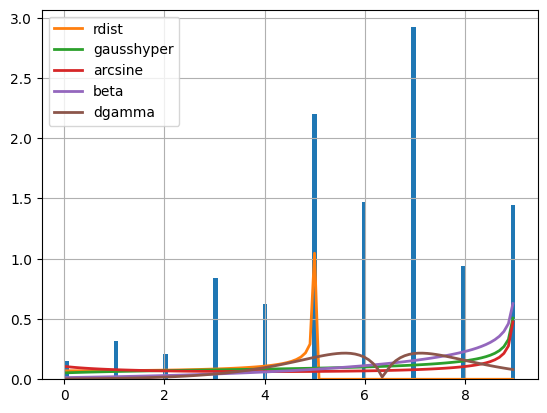

In [ ]:
from fitter import Fitter
f = Fitter(indices)
f.fit()
f.summary()

In [73]:
class DataInfo:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def get_slice(self):
        return slice(self.start, self.end)

    def get_size(self):
        return self.end - self.start


class DataInfoIter:
    def __init__(self, data, step=1):
        self.step = step
        self.data = data
        self.end = data.start

    def __iter__(self):
        return self

    def __next__(self):
        if self.end >= self.data.end:
            raise StopIteration

        start = self.end

        if self.end + self.step >= self.data.end:
            self.end = self.data.end
        else:
            self.end += self.step

        return DataInfo(start, self.end)



#TODO sınıf farklı veri setlerine göre kendini uyumlu hale getiremiyor, daha dinamik bir mimari uygulanması gerekli
class BondNet(keras.Model):
    def __init__(self, features: np.array, labels: np.array, num_unique_users, num_unique_movies, min_rating, max_rating,
                 rating_step=0.5, embedding_size=32, batch_size=32, train_split=0.6, val_split=0.2,
                 val=None, test=None, **kwds):
        '''bu fonksiyon katmanların ve diğer parameterlerin oluşturulduğu fonksiyondur'''


        if (train_split + val_split >= 1.0) or (len(features) != len(labels)):
            raise RuntimeError

        if ((val is not None) and (test is not None)):
            self.train = (features, labels)
            self.val = val
            self.test = test

            # self.features = np.vstack((features, val[0]))
            # self.features = np.vstack((features, test[0]))

            # self.labels = np.vstack((labels, val[1]))
            # self.labels = np.vstack((labels, test[1]))
        else:
            from sklearn.model_selection import train_test_split

            self.xtrain, self.xtest = train_test_split(features, test_size=(1 - (train_split + val_split)))
            self.ytrain, self.ytest = train_test_split(labels, test_size=(1 - (train_split + val_split)))

            self.xtrain, self.xval = train_test_split(self.xtrain, test_size=val_split / (train_split + val_split))
            self.ytrain, self.yval = train_test_split(self.ytrain, test_size=val_split / (train_split + val_split))

            self.train = (self.xtrain, self.ytrain)
            self.val = (self.xval, self.yval)
            self.test = (self.xtest, self.ytest)
            # self.features = features
            # self.labels = labels

        if (len(np.unique(np.concatenate((self.train[0][:, 0],self.val[0][:, 0],self.test[0][:, 0])))) != len(np.unique(self.train[0][:, 0]))):
            raise RuntimeError

        if (len(np.unique(np.concatenate((self.train[0][:, 1],self.val[0][:, 1],self.test[0][:, 1])))) != len(np.unique(self.train[0][:, 1]))):
            raise RuntimeError


        def ContiguousDataInfo(splits, start=0):
            data = []

            st = start
            end = start
            for sp in splits:
                end += sp
                data.append(DataInfo(st, end))
                st += sp

            return data




        super(BondNet, self).__init__(**kwds)

        ##TODO veriyi ayırma statik olarak belirlenmemeli, train fonksiyonunda parametre olarak alınmalı

        #GEÇİCİ
        num_unique_movies = len(np.unique(np.concatenate((x_train[:, 1],x_val[:, 1],x_test[:, 1]))))
        #GEÇİCİ

        # self.train_split, self.val_split, self.test_split = ContiguousDataInfo((int(train_split * len(self.features)), int(val_split * len(self.features)), int((1.0 - (train_split + val_split)) * len(self.features))))

        # self.train_split = (0, int(train_split * len(features)))
        # self.val_split = (int(train_split * len(features)), int(train_split * len(features)) + int(val_split * len(features)))
        # self.test_split = (int(train_split * len(features)) + int(val_split * len(features)), len(features))


        self.id_input, self.mfeature_input = ContiguousDataInfo((2, len(self.train[0][0, 2:])))

        #kullanıcılar ve filmler için kullanılacak embedding vektörlerinin uzunluğunun ne kadar olacağının tutulduğu değişken
        # self.id_input_slice = slice(0, 2)
        # self.mfeature_input_slice = slice(2, len(self.features[0, 2:]))
        self.boutput = DataInfo(0, int(((max_rating - min_rating) / rating_step) + 1))
        self.embedding_size = embedding_size
        self.batch_size = batch_size


        # U, V = self.__perform_SVD(self.features[:, self.id_input.get_slice()], self.labels, min_rating)


        #EMBEDDING API

        #burada hashing yaparak ilgili kullanıcı ve filmin aşağıda görülen embedding katmanında
        #hangi satıra denk geldiğini haritalandı
        #örneğin "42" numaralı kullanıcının embedding vektörü embedding katmanında "35" numaralı indise(satıra) denk gelebilir
        #çünkü kullanıcı veya film "id"leri 0'dan başlayarak birer birer artmak zorunda değil veya
        #integer bir değer olmak zorunda bile değil
        #bu yüzden bu değerleri ilgili kullanıcı veya film embedding vektörüne denk gelen satırın indisine göre haritalamamız gerekli
        self.user_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(np.unique(np.concatenate((self.train[0][:, 0],self.val[0][:, 0],self.test[0][:, 0]))), np.arange(num_unique_users)),
            default_value=0
        )
        self.movie_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(np.unique(np.concatenate((self.train[0][:, 1],self.val[0][:, 1],self.test[0][:, 1]))), np.arange(num_unique_movies)),
            default_value=0
        )

        #bu embedding vektörleri için alınan girişi barındıran katman
        #yani bu katman ile sadece "userId" ve "movieId" değerlerini alıyoruz
        #çünkü sadece bunlar embedding katmanları için kullanılacak, film türleri için farklı bir API kullanacağız
        self.embedding_input = keras.layers.InputLayer(
            input_shape=(self.id_input.get_size(),),
            dtype=np.int64
        )

        #burada collaborative filtering modelinde kullanılan matrix factorization metodunu kullanmak adına
        #her bir "tekil" kullanıcı ve filme "embedding_size" boyutunda bir embedding vektörü ve
        #her bir kullanıcı ve film özünde tekil kavramlar olduğu için birer integer sapma değeri(bias) tahsis edildi böylece
        #vektörler üzerinde dot product işlemi kullanılarak ve daha sonra sapma değerleri ile toplanarak ilgili puan elde edilebilir
        #daha sonra da modelin çıktısında tahmin edilen kullanıcının ilgili filme verdiği puan kategorisini
        #gerçekte olan kategori ile karşılaştırarak ilgili embedding vektörlerini
        #daha doğru sonucu verdiği değerlere doğru değiştirebiliriz
        #yani ilgili loss değerine göre ilgili vektör ağırlıklarını(weights)
        #daha doğru sonucu verdiği yönde(gradient descent işlemi) değiştirilebilir
        self.user_embedding = keras.layers.Embedding(
            input_dim=num_unique_users,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.L1L2(l1=3e-2, l2=3e-2)
        )
        self.user_bias = keras.layers.Embedding(
            input_dim=num_unique_users,
            output_dim=1
        )

        self.movie_embedding = keras.layers.Embedding(
            input_dim=num_unique_movies,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.L1L2(l1=3e-2, l2=3e-2)
        )
        self.movie_bias = keras.layers.Embedding(
            input_dim=num_unique_movies,
            output_dim=1
        )

        #VISIBLE FEATURES API

        #bu katman ise film türlerini giriş olarak alan katman
        #burada giriş olarak verilen film türleri ilgili gizli katmanlardan geçtikten sonra(şuan için 3 tane dense layer var)
        #iki boyuttan tek boyuta indirildiği(flatten layer ile) ve daha sonra kullanmak için hazır hale getirildiği katman
        #bu API'ın görevi "call" fonksiyonunda anlatılmıştır
        self.visible_input = keras.layers.InputLayer(
            input_shape=(self.mfeature_input.get_size(),),
            dtype=np.int8
        )
        self.dense1 = keras.layers.Dense(
            self.embedding_size * 16,
            activation="relu"
        )
        self.dense2 = keras.layers.Dense(
            self.embedding_size * 8,
            activation="relu"
        )
        self.dense3 = keras.layers.Dense(
            self.embedding_size * 4,
            activation="relu"
        )
        self.vis_drop = keras.layers.Dropout(0.2)
        self.visible_flatten = keras.layers.Flatten()

        #en önemli kısımlardan biri olan modelin çıkışını aldığımız katmanda ise kullanıcının ilgili filme verdiği puanın
        #hangi kategoriye ait olduğunun tahmini yapılıyor
        #örneğin en düşük puanın(min_rating) 0.0, en yüksek puanın(max_rating) 5.0 ve puan artım oranın(rating_step) 1.0 olduğu senaryoda
        #((5.0 - 0.0) / 1.0) + 1) = 6 olmak üzere toplam 6 tane kategori barındırdığı(bu kategoriler 0.0, 1.0, 2.0, 3.0, 4.0, 5.0)
        #ve çıktının da bu kategorilerden biri olarak seçildiği katmanın olduğu kısım bu çıktı katmanıdır
        #bu örneğe itafen eğer çıktı(çıktılar 6 elemanlı diziler olacak çünkü toplamda 6 kategori var)
        #[0, 0, 1, 0, 0, 0] ise seçilen kategori, kullanıcının ilgili filme "2.0" puanını verdiğini
        #tahmin eden değeri temsil eden kategoridir
        #[0, 0, 0, 0, 0, 1] ise seçilen kategori, max_rating değeri yani "5.0"dır
        self.output_labels = keras.layers.Dense(
            self.boutput.get_size(),
            activation="softmax"
        )

    def call(self, inputs):
        '''bu fonksiyon girişlerin modelin ilgili katmanlarına iletilmesini sağlayan fonksiyondur'''
        '''bu fonksiyonda bulunan "inputs" parametresi x_train değişkenin satırlarını barındırır'''
        '''yani kullanıcı, film "id"leri ve filmlerin türleri'''

        #x_train değişkeninde yer alan ilk iki eleman sırası ile "userId" ve "movieId" olduğu için bu "id"lere denk gelen
        #embedding vektörlerini bulmak adına hash tablosunda ilgili satırların indisi bulunur
        user_index = self.user_table.lookup(inputs[0][:, 0])
        movie_index = self.movie_table.lookup(inputs[0][:, 1])

        #daha sonra ilgili kullanıcılara ve filmlere denk gelen embedding vektörleri ve sapma değerleri(bias)
        #embedding ve sapma değerleri(bias) katmanından çekilir
        user_vector = self.user_embedding(user_index)
        user_bias = self.user_bias(user_index)

        movie_vector = self.movie_embedding(movie_index)
        movie_bias = self.movie_bias(movie_index)

        #matrix factorization metodunda kullanılan dot product işlemi
        #ilgili embedding vektörleri üzerinde uygulanır ve sapma değerleri ile toplanarak ilgili değerler elde edilir
        #dot_user_movie = tf.reduce_sum(tf.multiply(user_vector, movie_vector), axis=1)
        #dot_user_movie2 = tf.tensordot(user_vector, movie_vector, 2)
        #embed_out = tf.reshape(dot_user_movie + tf.transpose(user_bias) + tf.transpose(movie_bias), shape=(-1, 1))
        #embed_out2 = dot_user_movie2 + user_bias + movie_bias


        #hatırlanacağı üzere x_train değişkeninde 2. elemandan sonrası film türleri tutuyordu
        #bu film türleri "__init__" fonksiyonunda belirtilen gizli katmanlara giriş olarak verilerek
        #türlerin kodlandığı(encoding) değerler hesaplanır
        # genres_vector = self.vis_drop(self.dense3(self.dense2(self.dense1(self.visible_input(inputs[1])))))
        # genres_out = self.visible_flatten(genres_vector)

        embed_out_forw = tf.concat([user_vector + user_bias, movie_vector + movie_bias], axis=1)
        hidden_forw = self.vis_drop(self.dense3(self.dense2(self.dense1(embed_out_forw))))

        # tf.print(tf.shape(user_vector))
        # tf.print(tf.shape(user_bias))
        # tf.print(tf.shape(movie_vector))
        # tf.print(tf.shape(movie_bias))
        # tf.print(tf.shape(dot_user_movie2))
        # tf.print(tf.shape(embed_out2))
        # tf.print(tf.shape(embed_out_forw))
        # tf.print(tf.shape(hidden_forw))

        #bu embedding değerleri ile tür değerleri birleştirelerek çıkış katmanına giriş olarak verilmeye hazır hale getirilir
        # out = tf.concat([embed_out, hidden_forw], axis=1)

        #tf.print(tf.shape(hidden_forw))

        #ardından son katman olan sınıflandırmanın yapıldığı katmanda ise ilgili kullanıcıların ilgili filmlere
        #hangi puanı verdiğinin kategorisinin tahmininin yapılması sağlanır
        #daha sonra da, bahseldiği üzere tahmin edilen değer kategorisi ile gerçek değerin kategorisi karşılaştıralarak
        #ilgili embedding vektörlerinin değerlerinin ve
        #ilgili filmlerin türlerinin kodlarının(encoding) elde edilmesinin sağlayan
        #rgizli katmanlara(dense layers) matematiksel olarak gömülen değerlerin
        #gerçek değeri elde etmeye doğru iyileştirilmesi sağlanır
        return self.output_labels(hidden_forw)

    def __perform_SVD(self, features, labels, min):
        data = np.hstack((features, np.apply_along_axis(lambda x : np.nonzero(x)[0] * 0.5 + min, 1, labels)))


        rows, row_pos = np.unique(data[:, 0], return_inverse=True)
        cols, col_pos = np.unique(data[:, 1], return_inverse=True)

        pivot_table = np.zeros((len(rows), len(cols)), dtype=data.dtype)
        pivot_table[row_pos, col_pos] = data[:, 2]

        svd = TruncatedSVD(n_components=self.embedding_size, random_state=1337)
        U = svd.fit_transform(pivot_table)
        V = svd.components_.T

        return U, V

    def __data_gen(self, data, is_test=False):
        di = DataInfo(0, len(data[0]))
        iter = DataInfoIter(di, self.batch_size)

        for i in iter:
            yield (np.asarray(data[0][i.get_slice(), self.id_input.get_slice()], dtype=np.int64), \
                   np.asarray(data[0][i.get_slice(), self.mfeature_input.get_slice()], dtype=np.int8)), \
                   np.asarray(data[1][i.get_slice()], dtype=np.int8)
            # yield (np.asarray(self.features[i.get_slice(), self.id_input.get_slice()], dtype=np.int64), \
            #        np.asarray(self.features[i.get_slice(), self.mfeature_input.get_slice()], dtype=np.int8)), \
            #        np.asarray(self.labels[i.get_slice()], dtype=np.int8)

    def get_dataset(self):
        signature = ((tf.TensorSpec(shape=(None, self.id_input.get_size()), dtype=tf.int64),
                      tf.TensorSpec(shape=(None, self.mfeature_input.get_size()), dtype=tf.int8)),
                      tf.TensorSpec(shape=(None, self.boutput.get_size()), dtype=tf.int8))

        train_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen(self.train),
            output_signature=signature
        )

        val_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen(self.val),
            output_signature=signature
        )

        test_dataset = tf.data.Dataset.from_generator(
            lambda: self.__data_gen(self.test),
            output_signature=signature
        )

        return train_dataset, val_dataset, test_dataset

    #TODO model fonksiyonlarının kendi implementasyon biçimleri ile çağrılması gerek, keras API'i ile değil

    def cmpl():
        pass
    def trn():
        pass

In [74]:
bondnet = BondNet(
    x_train,
    y_train,
    num_unique_users,
    num_unique_movies,
    min_rating,
    max_rating,
    rating_step=0.5,
    embedding_size=64,
    val=(x_val, y_val),
    test=(x_test, y_test)
)

#modelde kullanılacak loss ve optimizer algoritmaları seçilir
bondnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="MeanSquaredLogarithmicError",
    metrics=[
        tf.keras.metrics.MeanSquaredError(),
        tf.keras.metrics.RootMeanSquaredError(),
        "accuracy"
    ]
)

In [75]:
tr, val, tst = bondnet.get_dataset()

In [ ]:
a1 = np.arange(32 * 4).reshape((32, 4))
a2 = np.arange(32 * 4).reshape((32, 4)) + np.arange(0, 32 * 4).reshape((32, 4))
b1 = np.arange(32 * 1).reshape((32, 1))
b2 = np.arange(32 * 1).reshape((32, 1)) + np.arange(0, 32 * 1).reshape((32, 1))
tf.reshape(tf.reduce_sum(tf.multiply(a1, a2), axis=1) + tf.transpose(b1) + tf.transpose(b1), shape=(-1, 1))

In [ ]:
for i in tst:
    print(i)
    break

In [76]:
#modelin eğitim aşaması fonksiyonlardan alınan veri setleri ile başlatılır

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=2
    )
]

history = bondnet.fit(
    tr.repeat(),
    epochs=10,
    batch_size=bondnet.batch_size,
    steps_per_epoch=len(bondnet.train[0]) // bondnet.batch_size,
    validation_steps=len(bondnet.val[0]) // bondnet.batch_size,
    validation_data=val.repeat(),
    callbacks=callback
)

Epoch 1/10


93709/93709 [==============================] - 2074s 22ms/step - loss: 2.2592 - mean_squared_error: 0.0192 - root_mean_squared_error: 0.1387 - accuracy: 0.8638 - val_loss: 2.2484 - val_mean_squared_error: 0.1403 - val_root_mean_squared_error: 0.3746 - val_accuracy: 0.2130
Epoch 2/10
93709/93709 [==============================] - 1988s 21ms/step - loss: 2.2049 - mean_squared_error: 0.0146 - root_mean_squared_error: 0.1209 - accuracy: 0.9042 - val_loss: 2.2806 - val_mean_squared_error: 0.1411 - val_root_mean_squared_error: 0.3757 - val_accuracy: 0.2045
Epoch 3/10
93709/93709 [==============================] - 1897s 20ms/step - loss: 2.2137 - mean_squared_error: 0.0161 - root_mean_squared_error: 0.1268 - accuracy: 0.8965 - val_loss: 2.2808 - val_mean_squared_error: 0.1443 - val_root_mean_squared_error: 0.3798 - val_accuracy: 0.2119


In [51]:
for k in history.history:
    print(k, ': ', history.history[k][-1])

loss :  2.58678936958313
mean_squared_error :  0.07602721452713013
root_mean_squared_error :  0.2757304012775421
accuracy :  0.3729066252708435
val_loss :  2.5505788326263428
val_mean_squared_error :  0.07888620346784592
val_root_mean_squared_error :  0.28086695075035095
val_accuracy :  0.32407405972480774


In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
eval = bondnet.evaluate(
    tst,
    batch_size=bondnet.batch_size,
    steps=len(bondnet.test[0]) // bondnet.batch_size
)

608/608 [==============================] - 3s 5ms/step - loss: 2.6094 - mean_squared_error: 0.0792 - root_mean_squared_error: 0.2814 - accuracy: 0.3150


In [ ]:
bondnet.summary()

Model: "bond_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 embedding (Embedding)       multiple                  39040     
                                                                 
 embedding_1 (Embedding)     multiple                  610       
                                                                 
 embedding_2 (Embedding)     multiple                  622336    
                                                                 
 embedding_3 (Embedding)     multiple                  9724      
                                                                 
 input_2 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               multiple                  225

**Embedding Size Hyperparameter**

In [ ]:
params = [5, 8, 10, 16, 32, 50, 64, 100, 128, 200, 256]

In [ ]:
histories = []

for emb in params:
    bondnet = BondNet(
        x_train,
        y_train,
        num_unique_users,
        num_unique_movies,
        min_rating,
        max_rating,
        rating_step=0.5,
        embedding_size=emb
    )

#modelde kullanılacak loss ve optimizer algoritmaları seçilir
    bondnet.compile(
        run_eagerly=True,
        optimizer="Adam",
        loss="MeanSquaredLogarithmicError",
        metrics=[
            tf.keras.metrics.MeanSquaredError(),
            tf.keras.metrics.RootMeanSquaredError(),
            "accuracy"
        ]
    )

    tr, val, tst = bondnet.get_dataset()

    #modelin eğitim aşaması fonksiyonlardan alınan veri setleri ile başlatılır
    histories.append(bondnet.fit(
        tr.repeat(),
        epochs=100,
        batch_size=bondnet.batch_size,
        steps_per_epoch=bondnet.train_split.get_size() // bondnet.batch_size,
        validation_steps=bondnet.val_split.get_size() // bondnet.batch_size,
        validation_data=val.repeat()
    ))

Epoch 1/50
189/189 [==============================] - 21s 108ms/step - loss: 5.9457 - mean_squared_error: 0.0874 - root_mean_squared_error: 0.2956 - accuracy: 0.2348 - val_loss: 5.2751 - val_mean_squared_error: 0.0843 - val_root_mean_squared_error: 0.2904 - val_accuracy: 0.2684
Epoch 2/50
189/189 [==============================] - 19s 103ms/step - loss: 4.8085 - mean_squared_error: 0.0845 - root_mean_squared_error: 0.2907 - accuracy: 0.2576 - val_loss: 4.3966 - val_mean_squared_error: 0.0839 - val_root_mean_squared_error: 0.2897 - val_accuracy: 0.2738
Epoch 3/50
189/189 [==============================] - 20s 107ms/step - loss: 4.0743 - mean_squared_error: 0.0840 - root_mean_squared_error: 0.2898 - accuracy: 0.2671 - val_loss: 3.7859 - val_mean_squared_error: 0.0837 - val_root_mean_squared_error: 0.2893 - val_accuracy: 0.2748
Epoch 4/50
189/189 [==============================] - 23s 121ms/step - loss: 3.5482 - mean_squared_error: 0.0837 - root_mean_squared_error: 0.2894 - accuracy: 0.27

In [ ]:
histories[0].history.keys()

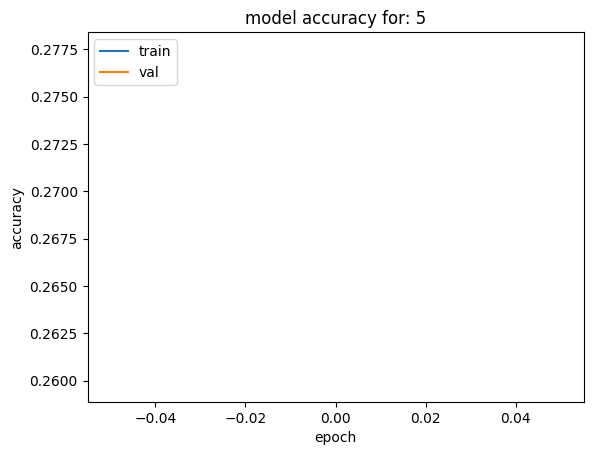

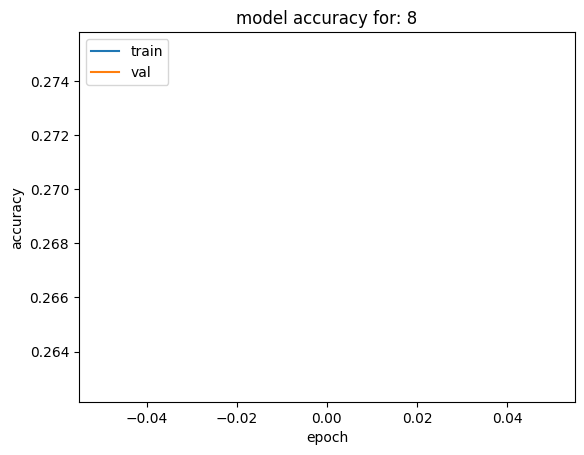

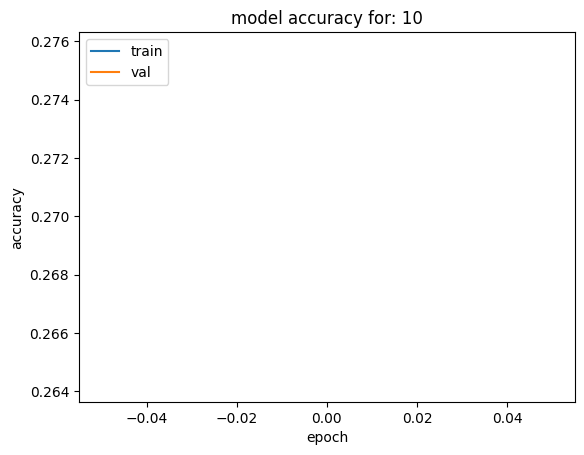

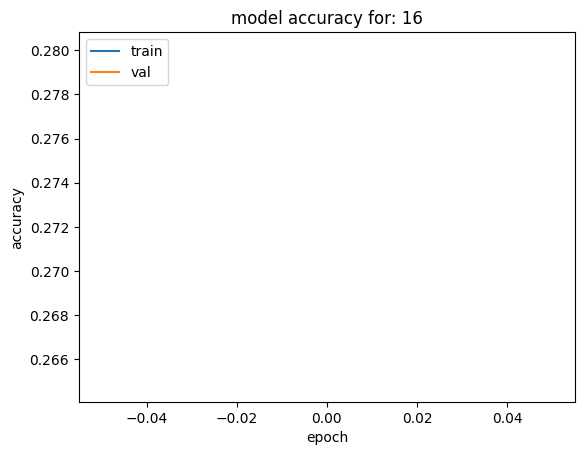

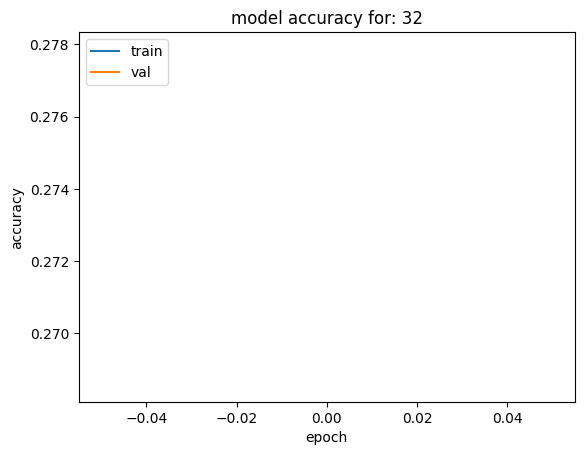

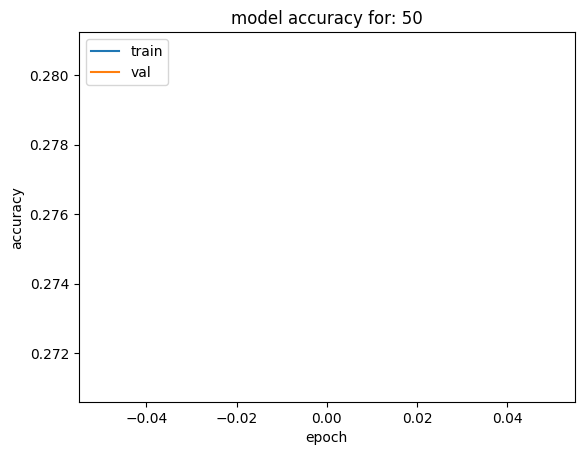

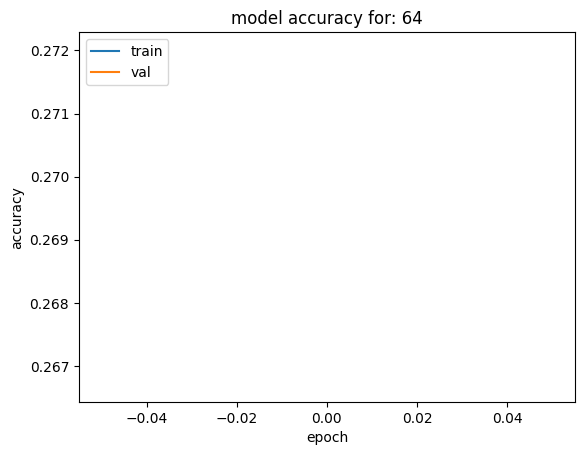

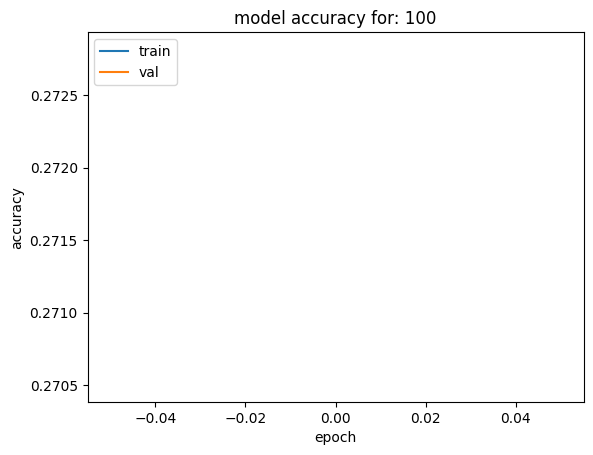

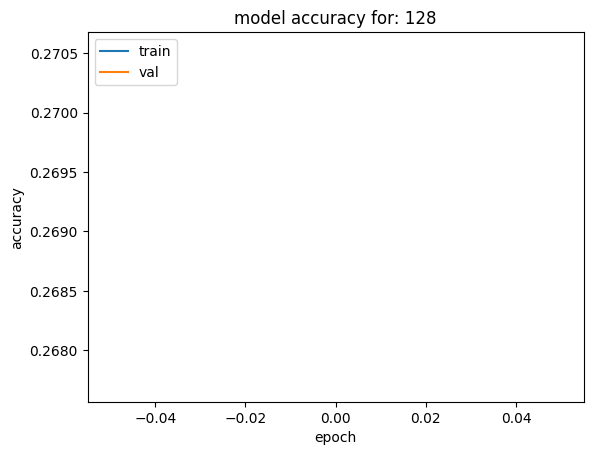

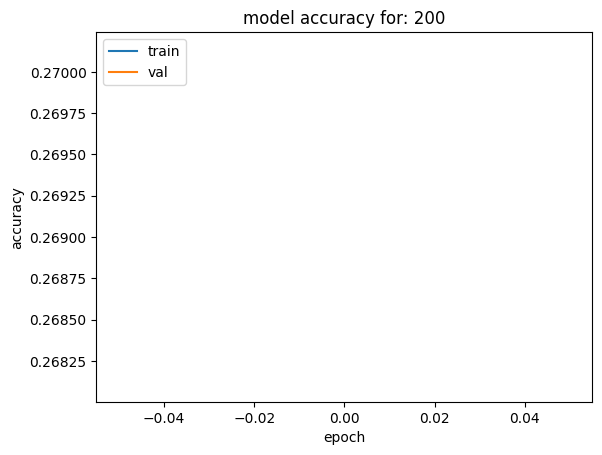

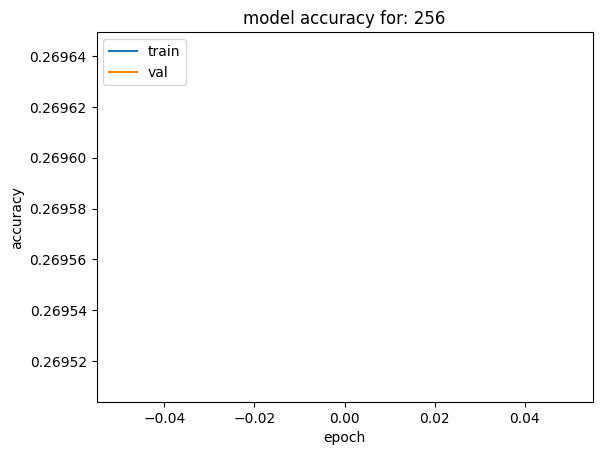

In [ ]:
i = 0

for hst in histories:
    plt.plot(hst.history['accuracy'])
    plt.plot(hst.history['val_accuracy'])
    plt.title('model accuracy for: {}'.format(params[i]))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    i += 1